# DietAI
~~~
Yapayzaka sinir ağları ile beslenme koçu oluşturma.

Okuldaki yapayzeka dersi için hazırladığım bu araştırmada temel anlamda bir beslenme koçu
oluşturmaya çalıştım. Projede temel hedefim günlük aldığım ve harcadığım kalorilerin yapayzeka ile
hesabını yapıp kilo alıp almayacağımı öğrenmek.

Malesef veri toplama ve yapay sinir ağı modelini oluşturma kısmında bazı sıkıntılar çektim.
Bu araştırmamı -yetersiz olsa da- bu alanda Türkçe çok az kaynak bulunduğu için paylaşmak istedim.
Umarım benden sonrakilere öncü olur.
~~~
## Gerekli modüller
|Modül adı | Kullanım alanı
|----------------------------------
|tempfile | Geçici depolama
|pandas | Veri işleme
|tensorflow | Yapay sinir ağı
|matplotlib | Veri görselleştirme

## Kurulum
~~~
Öncelikle bu projeyi tensorflow yüklenmese dahi sanal ortamda çalıştırmanızı tavsiye ederim.
pip3 install -r requirements.txt komutu ile gerekli modülleri kurabilirsiniz. Eğer sorun çıkarsa
modüllerin her birinin sitesinde detaylı kurulumları mevcut.

Kütüphaneleri elle yüklemek isterseniz
  sudo pip3 install tensorflow
  sudo pip3 install pandas
  sudo apt-get install python3-matplotlib
~~~

## Çalıştırma
~~~
jupyter-notebook DietAI.ipynb komutu ile bu dosyayı tarayıcı üstünde adım adım çalıştırabilirsiniz.
Daha çabuk sonuç almak istiyorsanız .py uzantılı dosyayı python3 ile çalıştırın.
~~~


In [1]:
import tempfile
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import datetime
%matplotlib inline

### Besin Verileri
~~~
Konumuz beslenme olduğu için haliyle besin verilerine ihtiyacımız var.
Aşağıda gördüğünüz ABBREV.csv dosyasında 92.000deb fazla besin kombinasyonunun detaylı bilgileri bulunmakta.
~~~

In [2]:
food_data = pd.DataFrame.from_csv("ABBREV.csv")
food_data.tail()

,Shrt_Desc,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),...,Vit_K_(µg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,GmWt_Desc1,GmWt_2,GmWt_Desc2,Refuse_Pct
No,,,,,,,,,,,,,,,,,,,,,
83110,"MACKEREL,SALTED",43.00,305,18.50,25.10,13.40,0.00,0.0,0.0,66.0,...,7.8,7.148,8.320,6.210,95.0,136.0,"1 cup, cooked",NaN,NaN,0.0
90240,"SCALLOP,(BAY&SEA),CKD,STMD",70.25,111,20.54,0.84,2.97,5.41,0.0,0.0,10.0,...,0.0,0.218,0.082,0.222,41.0,85.0,3 oz,NaN,NaN,0.0
90480,"SYRUP,CANE",26.00,269,0.00,0.00,0.86,73.14,0.0,73.2,13.0,...,0.0,0.000,0.000,0.000,0.0,NaN,NaN,NaN,NaN,0.0
90560,"SNAIL,RAW",79.20,90,16.10,1.40,1.30,2.00,0.0,0.0,10.0,...,0.1,0.361,0.259,0.252,50.0,85.0,3 oz,NaN,NaN,0.0
93600,"TURTLE,GREEN,RAW",78.50,89,19.80,0.50,1.20,0.00,0.0,0.0,118.0,...,0.1,0.127,0.088,0.170,50.0,85.0,3 oz,NaN,NaN,0.0


~~~
Yapayzeka modelimizi eğitmek için kişilerin günlük aktiviteleri ile ilgili bilgilerine ihtiyacımız var.
Ben internette bulamadığım için kendi 'yapay' verilerimi oluşturdum.

Öncelikle beslenme alışkanlığını temsil etmek için 8 saat aralıkları ile 10.000 adet zaman verisini içeren
bir tablo oluşturdum. Bu tabloda yaş, kilo, boy, cinsiyet, günlük kalori ihtiyacı, günlük kalori alımı ve 
yakımı ile ilgili bilgiler tutulacak.

Modelle işimi kolaylaştırmak için tablodaki bazı kolonları sabit değerler olarak tanımladım.

~~~

In [3]:
rng = pd.date_range(datetime.datetime.now(), periods=10000, freq='24H')
personal_data = pd.DataFrame(index=rng)
personal_data['age'] = 23
personal_data['weight'] = 75
personal_data['height'] = 176
personal_data['gender'] = "male"

In [4]:
personal_data.head()

,age,weight,height,gender
2016-12-29 02:49:24.148388,23,75,176,male
2016-12-30 02:49:24.148388,23,75,176,male
2016-12-31 02:49:24.148388,23,75,176,male
2017-01-01 02:49:24.148388,23,75,176,male
2017-01-02 02:49:24.148388,23,75,176,male


## Verilerin İşlenmesi
~~~
Besin tablosundan şimdilik işimize yarayacak olan 3 adet kolon var. 
Bunlar besin isimlerini içeren Shrt_Desc, kalori değerini içeren Energ_Kcal ve 
ölçüsünü belirten GmWt_1 kolonları.
~~~

In [5]:
food_data = food_data[['Shrt_Desc', 'Energ_Kcal', 'GmWt_1']]
food_data.head()

,Shrt_Desc,Energ_Kcal,GmWt_1
No,,,
1001,"BUTTER,WITH SALT",717,227.00
1002,"BUTTER,WHIPPED,WITH SALT",717,151.00
1003,"BUTTER OIL,ANHYDROUS",876,205.00
1004,"CHEESE,BLUE",353,28.35
1005,"CHEESE,BRICK",371,132.00


~~~
Günlük kalori ihtiyacını hesaplamak için Harris–Benedict formülünü kullanacağız.
Bu formül için cinsiyet, kilo, boy ve yaş değerlerine ihtiyacımız var.
Formül kadınlar ve erkekler için ağaşıdaki gibi
~~~
$$BMRman = (10 × weight) + (6.25 × height) - (5 × age) + 5$$
$$BMRwoman = (10 × weight) + (6.25 × height) - (5 × age) - 161$$

|Egzersiz Yoğunluğu|Günlük Kilokalori İhtiyacı
|----------------------------------------
|Çok az veya hiç|BMR x 1.2
|Hafif (haftada 1–3 gün)|BMR x 1.375
|Orta (haftada 3–5 gün)|BMR x 1.55
|Ağır(haftada 6–7 gün)|BMR x 1.725
|Çok Ağır (günde 2 kez, ekstra antreman)|BMR x 1.9
[Bu linkten](https://en.wikipedia.org/wiki/Harris%E2%80%93Benedict_equation) daha fazla bilgi edinebilirsiniz.


In [6]:
activites = {"low":lambda x:x*1.2, 
             "light":lambda x:x*1.375, 
             "mid":lambda x:x*1.55, 
             "heavy":lambda x:x*1.725, 
             "very_heavy":lambda x:x*1.9}

def kcal(gender, weight, height, age, activity):
    """ Formüle göre BMR hesaplar ve aktiviteye göre günlük kcal değerini çıkartır"""
    if gender == "male":
        return  activites[activity]((10 * weight) + (6.25 * height) - (5 * age) + 5)
    else:
        return  activites[activity]((10 * weight) + (6.25 * height) - (5 * age) - 161)

~~~
Önce tabloya rastgele aktiviteler ekledik. Tablodaki her satıra erişip kcal fonksiyonuna gerekli parametreleri verdik.
Dönen değerlerden bir liste oluşturup bu listeyi kcal -günlük kkalori ihtiyacı- olarak tabloya ekledik
~~~

In [7]:
personal_data['activity'] = [random.choice(list(activites.keys())) for x in range(len(personal_data))]
personal_data['kcal']=[kcal(person[1]['gender'], person[1]['weight'], person[1]['height'], person[1]['age'], person[1]['activity'])
            for person in personal_data.iterrows()]
personal_data.head()

,age,weight,height,gender,activity,kcal
2016-12-29 02:49:24.148388,23,75,176,male,very_heavy,3306.0
2016-12-30 02:49:24.148388,23,75,176,male,very_heavy,3306.0
2016-12-31 02:49:24.148388,23,75,176,male,heavy,3001.5
2017-01-01 02:49:24.148388,23,75,176,male,low,2088.0
2017-01-02 02:49:24.148388,23,75,176,male,very_heavy,3306.0


~~~
Eğitim verilerini oluşturmak için personal_data tablosundaki vatandaşa rastgele 3 öğün yemek yedireceğiz.
Yemek isimlerini ve kalori değerini de tabloya kolon olarak ekleyeceğiz. Bu işlem uzun sürebilir :)
~~~

In [8]:
personal_data['breakfast'] = [random.choice(list(food_data['Shrt_Desc']))  for x in range(len(personal_data))]
breakfast_kcal = [food_data.loc[food_data['Shrt_Desc'] == x, 'Energ_Kcal'] for x in list(personal_data['breakfast'])]
personal_data['breakfast_kcal'] = [k.iloc[0] for k in breakfast_kcal]

personal_data['lunch'] = [random.choice(list(food_data['Shrt_Desc']))  for x in range(len(personal_data))]
lunch_kcal = [food_data.loc[food_data['Shrt_Desc'] == x, 'Energ_Kcal'] for x in list(personal_data['lunch'])]
personal_data['lunch_kcal'] = [k.iloc[0] for k in lunch_kcal]

personal_data['dinner'] = [random.choice(list(food_data['Shrt_Desc']))  for x in range(len(personal_data))]
dinner_kcal = [food_data.loc[food_data['Shrt_Desc'] == x, 'Energ_Kcal'] for x in list(personal_data['dinner'])]
personal_data['dinner_kcal'] = [k.iloc[0] for k in dinner_kcal]

personal_data['total_kcal'] = personal_data['dinner_kcal'] + personal_data['lunch_kcal'] + personal_data['breakfast_kcal']

~~~
Ardından yediklerini yakması için her gün rastgele 1 saat egzersiz yaptıracağız. Elimizdeki egzersiz tablosunda egzersiz isimleri ve kilo başına dakikada yaktırdığı kkalori oranı bulunuyor.
~~~
[Bu linkte](https://www.acefitness.org/updateable/update_display.aspx?pageID=593) detaylar mevcut.

In [9]:
exercise_data = pd.read_csv("activity_costs.csv", sep=";")
exercise_data.head()

,Activity,Energy_Expenditure
0,Racquetball (recreational),0.07
1,Kayaking (leisure),0.04
2,Dancing (general),0.08
3,Golf (walking + bag),0.09
4,"Running (5 mph, 12 min/mile)",0.12


In [10]:
personal_data['workout'] = [random.choice(list(exercise_data['Activity']))  for x in range(len(personal_data))]
excercise_kcal = [exercise_data.loc[exercise_data['Activity'] == x, 'Energy_Expenditure'] for x in list(personal_data['workout'])]
personal_data['workout_kcal'] = [k.iloc[0] for k in excercise_kcal]
personal_data['workout_kcal'] = personal_data['workout_kcal']*personal_data['weight']*60 # energy_exp * weight * min
personal_data.head()

,age,weight,height,gender,activity,kcal,breakfast,breakfast_kcal,lunch,lunch_kcal,dinner,dinner_kcal,total_kcal,workout,workout_kcal
2016-12-29 02:49:24.148388,23,75,176,male,very_heavy,3306.0,"CANDIES,MARS SNACKFOOD US,SNICKERS CRUNCHER",488,"RICE,WHITE,STMD,CHINESE RESTAURANT",151,"SALAD DRSNG,PEPPERCORN DRSNG,COMM,REG",564,1203,Dancing (general),360.0
2016-12-30 02:49:24.148388,23,75,176,male,very_heavy,3306.0,"ASPARAGUS,CND,REG PK,SOL&LIQUIDS",15,"BEEF,GROUND,75% LN MEAT / 25% FAT,PATTY,CKD,PA...",248,"BEEF,BRISKET,WHL,LN&FAT,1/8""FAT,ALL GRDS,CKD,BRSD",331,594,Running (7.5 mph 8 min/mile),990.0
2016-12-31 02:49:24.148388,23,75,176,male,heavy,3001.5,"FAST FD,PIZZA CHAIN,14"" PIZZA,MEAT & VEG TOPPI...",244,"FAST FOODS,MINIATURE CINN ROLLS",403,"SWEET POTATO,CND,MSHD",101,748,Sweeping,225.0
2017-01-01 02:49:24.148388,23,75,176,male,low,2088.0,"PORK,FRSH,VAR MEATS&BY-PRODUCTS,EARS,FRZ,RAW",234,"CHEESE PRODUCT,PAST PROCESS,AMERICAN,RED FAT,F...",240,"NUTS,PILINUTS,DRIED",719,1193,Sitting Activities (very light),135.0
2017-01-02 02:49:24.148388,23,75,176,male,very_heavy,3306.0,HORNED MELON (KIWANO),44,"MCDONALD'S,BIG 'N TASTY (WITHOUT MAYONNAISE)",192,"MILK,DRY,NONFAT,INST,WO/ ADDED VIT A & VITAMIN D",358,594,"Cycling (stationary, 200W)",810.0


~~~
Tabloya gerekli tüm verileri ekledik şimdi egzersizde harcanan enerjinin öğünlerden alınanlardan fazla olanları 1 olarak etiketleyeceğiz. Böylece yapay sinir ağı için eğitim datasetini hazırlamış olacağız.
~~~

In [11]:
def calibrate_labels(data_frame):
    """ calculates intake and cost value diff and adds it as label to dataframe """
    data_frame['label'] = data_frame[['total_kcal', 'workout_kcal']].apply(lambda x: x['workout_kcal'] - x['total_kcal'] > 0, axis=1).astype(int)
    return data_frame

In [12]:
personal_data = calibrate_labels(personal_data)
personal_data.to_csv("my_data.csv")
personal_data.head()

,age,weight,height,gender,activity,kcal,breakfast,breakfast_kcal,lunch,lunch_kcal,dinner,dinner_kcal,total_kcal,workout,workout_kcal,label
2016-12-29 02:49:24.148388,23,75,176,male,very_heavy,3306.0,"CANDIES,MARS SNACKFOOD US,SNICKERS CRUNCHER",488,"RICE,WHITE,STMD,CHINESE RESTAURANT",151,"SALAD DRSNG,PEPPERCORN DRSNG,COMM,REG",564,1203,Dancing (general),360.0,0
2016-12-30 02:49:24.148388,23,75,176,male,very_heavy,3306.0,"ASPARAGUS,CND,REG PK,SOL&LIQUIDS",15,"BEEF,GROUND,75% LN MEAT / 25% FAT,PATTY,CKD,PA...",248,"BEEF,BRISKET,WHL,LN&FAT,1/8""FAT,ALL GRDS,CKD,BRSD",331,594,Running (7.5 mph 8 min/mile),990.0,1
2016-12-31 02:49:24.148388,23,75,176,male,heavy,3001.5,"FAST FD,PIZZA CHAIN,14"" PIZZA,MEAT & VEG TOPPI...",244,"FAST FOODS,MINIATURE CINN ROLLS",403,"SWEET POTATO,CND,MSHD",101,748,Sweeping,225.0,0
2017-01-01 02:49:24.148388,23,75,176,male,low,2088.0,"PORK,FRSH,VAR MEATS&BY-PRODUCTS,EARS,FRZ,RAW",234,"CHEESE PRODUCT,PAST PROCESS,AMERICAN,RED FAT,F...",240,"NUTS,PILINUTS,DRIED",719,1193,Sitting Activities (very light),135.0,0
2017-01-02 02:49:24.148388,23,75,176,male,very_heavy,3306.0,HORNED MELON (KIWANO),44,"MCDONALD'S,BIG 'N TASTY (WITHOUT MAYONNAISE)",192,"MILK,DRY,NONFAT,INST,WO/ ADDED VIT A & VITAMIN D",358,594,"Cycling (stationary, 200W)",810.0,1


In [13]:
personal_data.columns

Index(['age', 'weight', 'height', 'gender', 'activity', 'kcal', 'breakfast',
       'breakfast_kcal', 'lunch', 'lunch_kcal', 'dinner', 'dinner_kcal',
       'total_kcal', 'workout', 'workout_kcal', 'label'],
      dtype='object')

~~~
Opsiyonel olarak tablodaki ilk n veriyi test verisi olarak kaydettik. 
İlerde bu programı tekrar çalıştırdığımızda veriler rastgele atanacağı için eski test verileri 
bizim için tutarlı ama farklı değerler olmuş olacak.
~~~

## Verileri Görselleştirelim
~~~
Günlük alınan ve harcanan kcal miktarı.
~~~

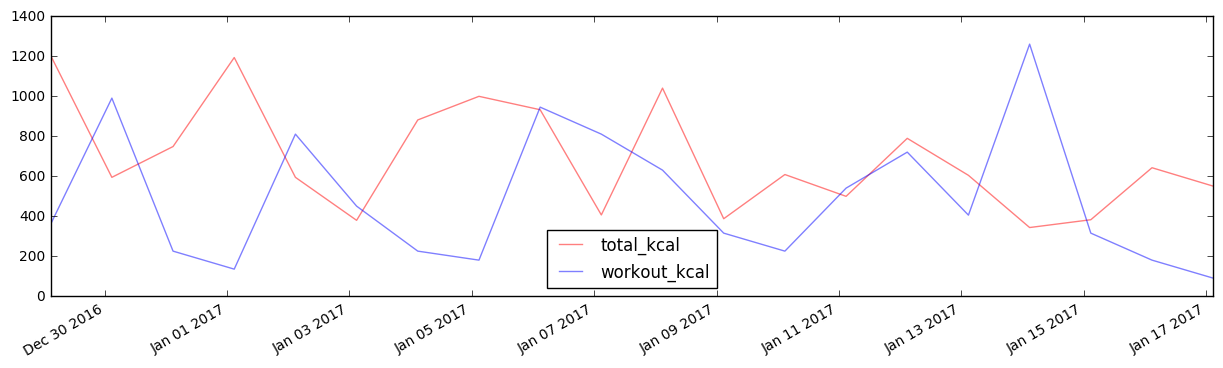

In [14]:
personal_data[['total_kcal', 'workout_kcal']][:20].plot(color=["r", "b"], figsize=(15, 4), fontsize=10, alpha=0.5)

~~~
1. Pastada alınan ve verilen kilo oranlarını,
2. Pastada günlük kalori ihtiyaç türlerinin oranlarını çizdirdik.
~~~

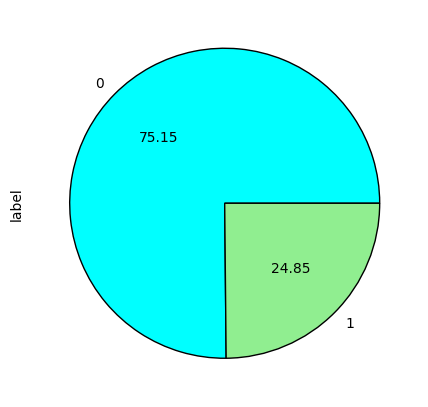

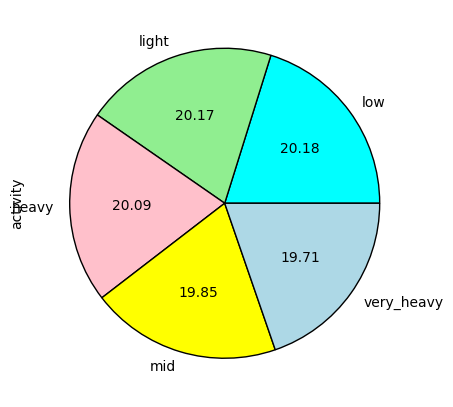

In [15]:
personal_data['label'].value_counts().plot.pie(autopct="%.2f", colors=("cyan", "lightgreen"), figsize=(5, 5));
plt.figure();
personal_data['activity'].value_counts().plot.pie(autopct="%.2f", colors=("cyan", "lightgreen", "pink", "yellow", "lightblue"), figsize=(5, 5));

~~~
Öğünlerde alınan kkalorilerin kümülatif toplamı (tüm değerler sırayla toplanır).
~~~

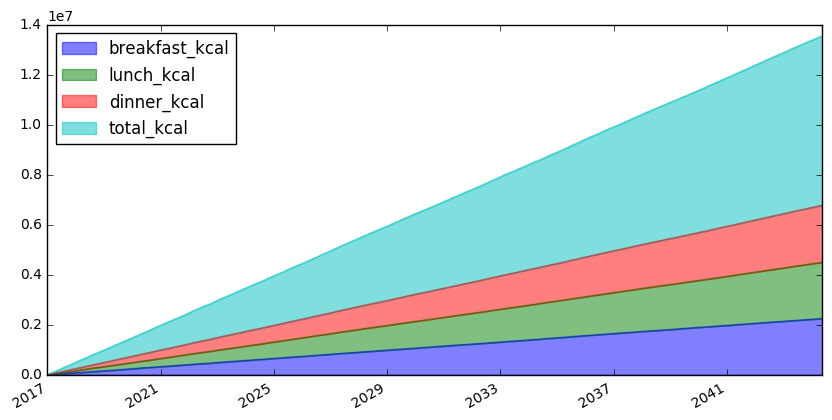

In [16]:
personal_data[['breakfast_kcal', 'lunch_kcal', 'dinner_kcal', 'total_kcal']].cumsum().plot.area(figsize=(10,5), alpha=0.5)

# Yapay Sinir Ağı

~~~
Bu örnekte wide and deep learning tekniğini kullandık. 
Basitçe açıklamak gerekirse 'wide' olarak belirlediğimiz kısım ezberleme (Linear Classification),
'deep' olarak belirlediğimiz katmanlı sinir ağı ile sınıflandırma yapacağız.

Wide and deep learning tekniği büyük ölçekli regresyonlar (veriler arasındaki ilişkinin analizi) ve sparse (çok sayıda olası değerlerin bulunduğu veya kategorinin çok sayıda parçaya bölündüğü) sınıflandırma problemlerinde etkili.
~~~
[Burada](https://research.googleblog.com/2016/06/wide-deep-learning-better-together-with.html) wide & deep learning ile ilgili güzel bir blog yazısı var.
[Burada](https://www.tensorflow.org/tutorials/wide_and_deep/) da tensorflowun kendi örneği var.

![alt text](wide_n_deep.svg "Genis ve Derin Ogrenme")

~~~
Aşağıda sürekli ve kategorisel kolonları ve model için gerekli bazı değişkenleri belirledik.
~~~
### Sürekli
    * age
    * weight
    * height
    * kcal
    * breakfast_kcal
    * lunch_kcal
    * dinner_kcal
    * total_kcal
    * workout_kcal
    
### Kategorsel
    * gender
    * activity
    * breakfast
    * lunch
    * dinner
    * workout

In [17]:
flags = tf.app.flags
FLAGS = flags.FLAGS

flags.DEFINE_string("model_dir", "", "Base directory for output models.")
flags.DEFINE_string("model_type", "wide_n_deep",
                    "Valid model types: {'wide', 'deep', 'wide_n_deep'}.")
flags.DEFINE_string(
    "train_data",
    "",
    "Path to the training data.")
flags.DEFINE_string(
    "test_data",
    "",
    "Path to the test data.")

COLUMNS = ['age', 'weight', 'height', 'gender', 'activity', 'kcal', 'breakfast',
       'breakfast_kcal', 'lunch', 'lunch_kcal', 'dinner', 'dinner_kcal',
       'total_kcal', 'workout', 'workout_kcal', 'label']
LABEL_COLUMN = "label"
CONTINUOUS_COLUMNS =  ['age', 'weight', 'height', 'kcal', 'breakfast_kcal', 'lunch_kcal', 'dinner_kcal', 'total_kcal', 'workout_kcal']
CATEGORICAL_COLUMNS= ["gender", 'activity', 'breakfast', 'lunch', 'dinner', 'workout']

In [18]:
def build_estimator(model_dir):
    """ Yapay sinir aği modeli."""
    # Sparse temel kolon
    gender = tf.contrib.layers.sparse_column_with_keys(column_name="gender",
                                                     keys=["female", "male"])
    
    # Surekli
    age = tf.contrib.layers.real_valued_column("age")
    weight = tf.contrib.layers.real_valued_column("weight")
    height = tf.contrib.layers.real_valued_column("height")
    kcal = tf.contrib.layers.real_valued_column("kcal")
    breakfast_kcal = tf.contrib.layers.real_valued_column("breakfast_kcal")
    lunch_kcal = tf.contrib.layers.real_valued_column("lunch_kcal")
    dinner_kcal = tf.contrib.layers.real_valued_column("dinner_kcal")
    total_kcal = tf.contrib.layers.real_valued_column("total_kcal")
    workout_kcal = tf.contrib.layers.real_valued_column("workout_kcal")

    # Kategorisel
    age_buckets = tf.contrib.layers.bucketized_column(age, boundaries=[
                                                        18, 25, 30, 35, 40, 45,
                                                        50, 55, 60, 65])
    
    activity = tf.contrib.layers.sparse_column_with_hash_bucket(
      "activity", hash_bucket_size=5)
    # öğünlerin türü belirlenebilirse hash_bucket_size daha tutarlı tanımlanabilir.
    breakfast = tf.contrib.layers.sparse_column_with_hash_bucket(
      "breakfast", hash_bucket_size=1000)
    lunch = tf.contrib.layers.sparse_column_with_hash_bucket(
      "lunch", hash_bucket_size=1000)
    dinner = tf.contrib.layers.sparse_column_with_hash_bucket(
      "dinner", hash_bucket_size=1000)
    
    workout = tf.contrib.layers.sparse_column_with_hash_bucket(
      "workout", hash_bucket_size=60) # 60 farklı egzersizimiz var
    
    # Wide columns and deep columns.
    wide_columns = [gender, age_buckets, activity, breakfast, lunch, dinner, workout]
    
    
    deep_columns = [
        tf.contrib.layers.embedding_column(gender, dimension=8),
        age,
        weight,
        height,
        kcal,
        breakfast_kcal,
        lunch_kcal,
        dinner_kcal,
        total_kcal,
        workout_kcal
    ]

    if FLAGS.model_type == "wide":
        m = tf.contrib.learn.LinearClassifier(model_dir=model_dir,
                                          feature_columns=wide_columns)
    elif FLAGS.model_type == "deep":
        m = tf.contrib.learn.DNNClassifier(
            model_dir=model_dir,
            feature_columns=deep_columns,
            hidden_units=[200, 100],  # gizli katma ve tensor sayısı
            optimizer=tflearn.optimizers.SGD(learning_rate=0.001), # Adam, SGD, RMSprop, RMSprop, Ftrl, AdaGrad 
            )
    else:
        m = tf.contrib.learn.DNNLinearCombinedClassifier(
            model_dir=model_dir,
            linear_feature_columns=wide_columns,
            dnn_feature_columns=deep_columns,
            dnn_hidden_units=[100, 50])
    return m

In [19]:
def input_fn(df):
    """ Kolonları tensorflow sabitlerine dönüştürür ve birleştirir. """
   
    continuous_cols = {k: tf.constant(df[k].values) for k in CONTINUOUS_COLUMNS}
    
    categorical_cols = {k: tf.SparseTensor(
        indices=[[i, 0] for i in range(df[k].size)],
        values=df[k].values,
        shape=[df[k].size, 1])
                      for k in CATEGORICAL_COLUMNS}
    
    feature_cols = dict(continuous_cols)
    feature_cols.update(categorical_cols)
    label = tf.constant(df[LABEL_COLUMN].values)

    return feature_cols, label

~~~
Geçici bir klasor içinde modeli oluşturduk.
~~~

In [20]:
model_dir = tempfile.mkdtemp()
m = build_estimator(model_dir) 

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'save_checkpoints_secs': 600, 'keep_checkpoint_every_n_hours': 10000, '_evaluation_master': '', '_task_type': None, '_num_ps_replicas': 0, 'save_checkpoints_steps': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fde843bfc88>, 'keep_checkpoint_max': 5, 'save_summary_steps': 100, 'tf_random_seed': None, '_task_id': 0, '_environment': 'local', '_is_chief': True, '_master': '', 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
}


~~~
Hazırladığımız tabloyu input_fn fonksiyonu ile tensorflow için hazır hale getirdik ve modelimize
verdik. 2. parametre olarak modeli eğitme işleminin kaç kez gerçekleştirileceğini belirledik.
~~~

In [21]:
train_res = m.fit(input_fn=lambda: input_fn(personal_data), steps=2000)

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scal

~~~
Önceden kaydettiğimiz test dosyasını (personal_data'ın bir parçası da olabilir) modelimize verdik
ve yine tekrar sayısını belirledik.
~~~

In [22]:
personal_test = pd.read_csv("my_test.csv")

In [23]:
results = m.evaluate(input_fn=lambda: input_fn(personal_test), steps=1000)

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scal

~~~
Son olarak test tablosundan 10 değer aldık ve tahmin etmesi için modele verdik.
~~~

In [24]:
sample = personal_test[10:20]
sample.head()

,Unnamed: 0,age,weight,height,gender,activity,kcal,breakfast,breakfast_kcal,lunch,lunch_kcal,dinner,dinner_kcal,total_kcal,workout,workout_kcal,label
10,2017-01-08 02:24:13.995011,23,75,176,male,mid,2697.0,"BEEF,CHUCK,CLOD,TOP BLADE,STEAK,LN & FAT,0"" FA...",176,"PUDDINGS,BANANA,DRY MIX,INST,W/ ADDED OIL",386,"PEANUTS,ALL TYPES,RAW",567,1129,Weeding/Gardening,315.0,0
11,2017-01-09 02:24:13.995011,23,75,176,male,very_heavy,3306.0,"CARROTS,CND,NO SALT,SOL&LIQUIDS",23,"PACE,SALSA REFRIED BNS",60,"FRANKFURTER,BF,UNHTD",313,396,Running 5.5 mph (11 min/mile),630.0,1
12,2017-01-10 02:24:13.995011,23,75,176,male,heavy,3001.5,"BABYFOOD,TEETHING BISCUITS",391,"SESAME FLOUR,HIGH-FAT",526,KELLOGG'S EGGO LOWFAT BLUEBERRY NUTRI - GRAIN ...,208,1125,Carrying Groceries (light),315.0,0
13,2017-01-11 02:24:13.995011,23,75,176,male,low,2088.0,"PORK,FRSH,SPARERIBS,LN&FAT,CKD,BRSD",397,"SAUCE,BARBECUE,SWT BABY RAY'S,ORIGINAL",192,KRAFT VELVEETA LT RED FAT PAST PROCESS CHS PRO...,222,811,Chopping Wood,405.0,0
14,2017-01-12 02:24:13.995011,23,75,176,male,very_heavy,3306.0,"BEEF,TOP SIRLOIN,STEAK,LN & FAT,1/8"" FAT,ALL G...",201,"OIL,INDUSTRIAL,SOY,REFINED,FOR WOKS & LT FRYING",884,"BABYFOOD,DINNER,VEG&CHICK,JR",53,1138,"Sexual Activity (kissing, hugs)",90.0,0


In [25]:
res = m.predict(input_fn=lambda:input_fn(sample)) 

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scal

### 0.99599999% doğruluk oranı gayet başarılı :)

In [26]:
import pprint
pprint.pprint(results)
for gercek, tahmin in zip([x for x in sample['label']], [next(res) for x in range(10)]):
    print("Gercek: {}, Tahmin Edilen: {} ".format(gercek, tahmin))

{'accuracy': 0.99599999,
 'accuracy/baseline_label_mean': 0.24699999,
 'accuracy/threshold_0.500000_mean': 0.99599999,
 'auc': 0.99989247,
 'global_step': 2002,
 'labels/actual_label_mean': 0.24699999,
 'labels/prediction_mean': 0.24570338,
 'loss': 0.010090809,
 'precision/positive_threshold_0.500000_mean': 0.98795182,
 'recall/positive_threshold_0.500000_mean': 0.99595141}
INFO:tensorflow:Loading model from checkpoint: /tmp/tmpxg2sbwit/model.ckpt-2002-?????-of-00001.
Gercek: 0, Tahmin Edilen: 0 
Gercek: 1, Tahmin Edilen: 1 
Gercek: 0, Tahmin Edilen: 0 
Gercek: 0, Tahmin Edilen: 0 
Gercek: 0, Tahmin Edilen: 0 
Gercek: 1, Tahmin Edilen: 1 
Gercek: 0, Tahmin Edilen: 0 
Gercek: 1, Tahmin Edilen: 1 
Gercek: 1, Tahmin Edilen: 1 
Gercek: 0, Tahmin Edilen: 0 
